# Precision & speed

```{important}
*spotter* is an **approximate** forward model. Light curves precision is expected to be **no better than 1 ppm** for most practical applications.
```

## Overall precision

The overall light curve precision of *spotter* depends on the resolution of the surface, which depends on the number of HEALPix sides used to describe it. A lower bound on the precision can be simply computed with

In [6]:
import healpy as hp

n_sides = 100
lower_precision = 1 / hp.nside2npix(n_sides)

print(f"{lower_precision:.2e}")

8.33e-06


Let's plot the precision for different number of HEALPix sides

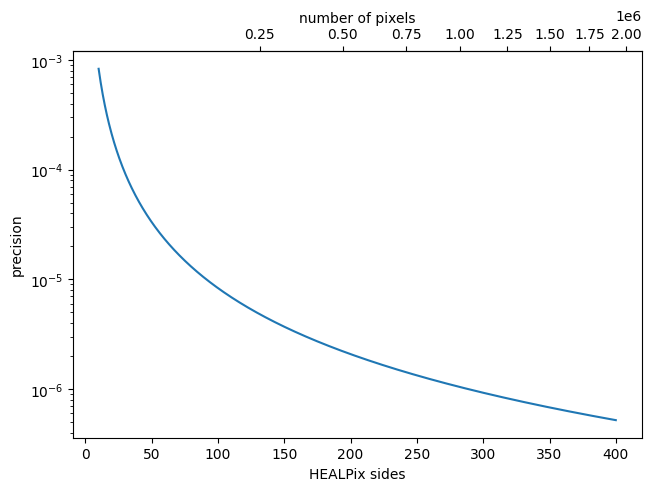

In [7]:
import numpy as np
import matplotlib.pyplot as plt

Ns = np.linspace(10, 400, 1000)
precision = 1 / np.vectorize(hp.nside2npix)(Ns)

fig, ax = plt.subplots(layout="constrained")
ax.plot(Ns, precision)
secax = ax.secondary_xaxis(
    "top", functions=(hp.nside2npix, lambda x: np.sqrt(x / 12.0))
)
secax.set_xlabel("number of pixels")

plt.yscale("log")
plt.ylabel("precision")
_ = plt.xlabel("HEALPix sides")

## Transit light curves

In order to evaluate transit light curves, *spotter* project the exoplanet disk onto the stellar surface pixels. This leads to high errors depending on the number of HEALPix sides used. 

Let's show the exoplanet pixelated disk for different number of sides.

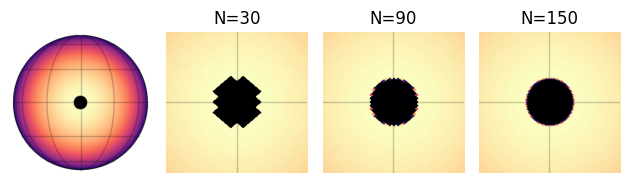

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from spotter import Star, light_curves, viz


star = Star.from_sides(100)
N = np.linspace(30, 150, 3).astype(int)
r = 0.1

plt.subplot(1, len(N) + 1, 1)
X = light_curves.transit_design_matrix(Star.from_sides(100), 0, 0, 1, r, 0)
viz.show(X[0])

for i, n in enumerate(N):
    plt.subplot(1, len(N) + 1, i + 2)
    X = light_curves.transit_design_matrix(Star.from_sides(int(n)), 0, 0, 1, r, 0)
    viz.show(X[0])
    plt.xlim(3 * np.array([-1, 1]) * r)
    plt.ylim(3 * np.array([-1, 1]) * r)
    plt.title(f"N={n}")

plt.tight_layout()

Let now see the effect on a light curve precision

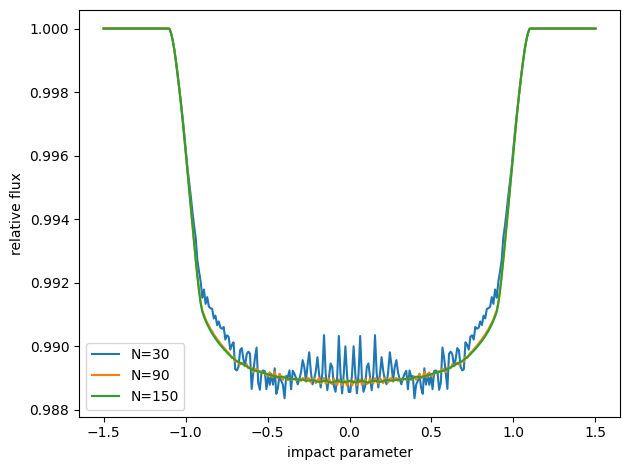

In [9]:
import jax
from spotter import light_curves

# impact parameter
b = np.linspace(-1.5, 1.5, 300)

for i, n in enumerate(N):
    star = star.from_sides(int(n), u=(0.1, 0.4))
    flux = jax.vmap(lambda b: light_curves.transit_light_curve(star, y=b, z=1, r=r))(b)
    plt.plot(b, flux, label=f"N={n}")

plt.legend()
plt.xlabel("impact parameter")
plt.ylabel("relative flux")
plt.tight_layout()

In this case too, the number computed in the last section provides a good **lower bound** on the light curve precision.

## Speed

For reference, below are some figures to benchmark the speed of spotter

/var/folders/ks/1v3kv1x10hj_1l_6vgf770640000gn/T/ipykernel_10543/2442304826.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


benchmark for pixels:   0%|          | 0/20 [00:00<?, ?it/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


benchmark for n time samples:   0%|          | 0/20 [00:00<?, ?it/s]

/Users/lionelgarcia/code/spotter/.venv/lib/python3.11/site-packages/healpy/pixelfunc.py:1080: RuntimeWarning: divide by zero encountered in divide
  pixarea = 4 * np.pi / nside2npix(nside)


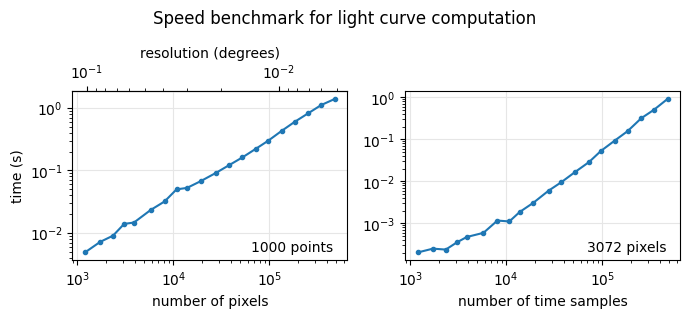

In [ ]:
import jax

device = "cpu"

jax.config.update("jax_platform_name", device)

import numpy as np
import healpy as hp

from time import time
import jax
from spotter.light_curves import light_curve
from spotter import Star
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

sides = np.logspace(np.log10(10), np.log10(200), 20)
sides = np.round(sides).astype(int)
sides -= sides % 2
pixels = np.sort(np.unique([hp.nside2npix(N) for N in sides]))

n = 2

time_samples = np.linspace(0, 1, 1000)
times_for_1000_times = []

for N in tqdm(pixels, desc="benchmark for pixels"):
    y = np.random.rand(N)
    star = Star(y, u=(0.5, 0.2), inc=1.2, period=1.0)
    lc = jax.jit(light_curve)
    jax.block_until_ready(lc(star, time_samples)[0])
    _ = []
    for i in range(n):
        tic = time()
        jax.block_until_ready(lc(star, time_samples)[0])
        _.append(time() - tic)
    times_for_1000_times.append(np.median(_))


times_samples = np.sort(np.unique(np.round(np.logspace(0, 5, 20)).astype(int)))
times_for_some_pixels = []
y = np.random.rand(hp.nside2npix(2**4))
star = Star(y, u=(0.5, 0.2), inc=1.2, period=1.0)
lc = jax.jit(light_curve)

for N in tqdm(times_samples, desc="benchmark for n time samples"):
    time_samples = np.linspace(0, 1, N)
    jax.block_until_ready(lc(star, time_samples)[0])
    _ = []
    for i in range(n):
        tic = time()
        jax.block_until_ready(lc(star, time_samples)[0])
        _.append(time() - tic)
    times_for_some_pixels.append(np.median(_))

fig, axes = plt.subplots(1, 2, figsize=(7, 3.2))
axes[0].plot(pixels, times_for_1000_times, ".-", label=device)
secax = axes[0].secondary_xaxis(
    "top",
    functions=(
        lambda x: hp.nside2resol(np.sqrt(x / 12.0)),
        lambda x: hp.nside2resol(np.sqrt(x / 12.0)),
    ),
)
secax.set_xlabel("resolution (degrees)")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("number of pixels")
axes[0].set_ylabel("time (s)")
axes[0].grid(color="0.9")
axes[0].text(0.95, 0.05, "1000 points", ha="right", transform=axes[0].transAxes)


axes[1].plot(pixels, times_for_some_pixels, ".-", label=device)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("number of time samples")
axes[1].grid(color="0.9")
axes[1].text(0.95, 0.05, f"{len(y)} pixels", ha="right", transform=axes[1].transAxes)

plt.suptitle("Evaluation time of the flux forward model")
plt.tight_layout()

benchmark for wavelengths:   0%|          | 0/20 [00:00<?, ?it/s]

benchmark for pixels:   0%|          | 0/19 [00:00<?, ?it/s]

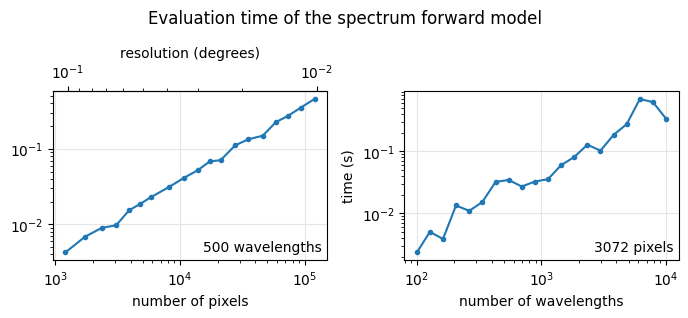

In [11]:
import jax.numpy as jnp
from spotter.doppler import spectrum

base_star = Star.from_sides(2**4, period=0.02, u=(0.2, 0.2), inc=1.4)

pixels = hp.nside2npix(2**4)

times_for_wv = []
n_wls = np.logspace(2, 4, 20).astype(int)
f = jax.jit(spectrum)

for n_wl in tqdm(n_wls, desc="benchmark for wavelengths"):
    wv = jnp.linspace(400, 410, n_wl) * 1e-9
    spectra = np.random.rand(n_wl, pixels)
    star = base_star.set(y=spectra, wv=wv)
    jax.block_until_ready(f(star, 0.1))
    _ = []
    for i in range(n):
        tic = time()
        jax.block_until_ready(f(star, 0.1))
        _.append(time() - tic)
    times_for_wv.append(np.median(_))

times_for_pix = []
n_wl = 500
wv = jnp.linspace(400, 410, n_wl) * 1e-9
sides = np.logspace(1, 2.0, 20)
sides = np.round(sides).astype(int)
sides -= sides % 2
pixels = np.sort(np.unique([hp.nside2npix(N) for N in sides]))
f = jax.jit(spectrum)

for N in tqdm(pixels, desc="benchmark for pixels"):
    spectra = np.random.rand(n_wl, N)
    star = base_star.set(y=spectra, wv=wv)
    jax.block_until_ready(f(star, 0.1))
    _ = []
    for i in range(n):
        tic = time()
        jax.block_until_ready(f(star, 0.1))
        _.append(time() - tic)
    times_for_pix.append(np.median(_))

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(7, 3.2))
axes[1].plot(n_wls, times_for_wv, ".-", label=device)
secax = axes[0].secondary_xaxis(
    "top",
    functions=(
        lambda x: hp.nside2resol(np.sqrt(x / 12.0)),
        lambda x: hp.nside2resol(np.sqrt(x / 12.0)),
    ),
)
secax.set_xlabel("resolution (degrees)")
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("number of wavelengths")
axes[1].set_ylabel("time (s)")
axes[1].grid(color="0.9")
axes[0].text(0.98, 0.05, "500 wavelengths", ha="right", transform=axes[0].transAxes)


axes[0].plot(pixels, times_for_pix, ".-", label=device)
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("number of pixels")
axes[0].grid(color="0.9")
axes[1].text(
    0.98, 0.05, f"{base_star.size} pixels", ha="right", transform=axes[1].transAxes
)

plt.suptitle("Evaluation time of the spectrum forward model")
plt.tight_layout()